# Baseline

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#read in all the words
words = open('names.txt','r').read().splitlines()
words[0:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
# build the vocabulary of characters and mappings to/from integer
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)} # character to integer
stoi['.']=0
itos = {i:s for s,i in stoi.items()} # integer to chatacter
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
# build the dataset with splits
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
g = torch.Generator().manual_seed(2148483647)
C = torch.randn((27,10),generator = g)
W1 = torch.randn((30,200), generator = g)
b1 = torch.randn(200, generator = g)
W2 = torch.randn((200,27), generator = g)
b2 = torch.randn(27, generator = g)
parameters = [C, W1, b1, W2, b2]

In [6]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [7]:
for p in parameters:
    p.requires_grad = True

In [8]:
#hyperparameters
lr = 0.1
batch_size = 32

In [9]:
lossi = []
stepi = []

In [10]:
for i in range(200000):
    
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    
    #forward pass
    emb = C[Xtr[ix]] # (32,10,3) 
    h = torch.tanh(emb.view(-1,30) @ W1 + b1) # (32,100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    if i%100000==49999:
        lr = lr/4
        print(f'lr was changed to value: {lr}')
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    stepi.append(i)
    lossi.append(loss.log10().item()) 

lr was changed to value: 0.025
lr was changed to value: 0.00625


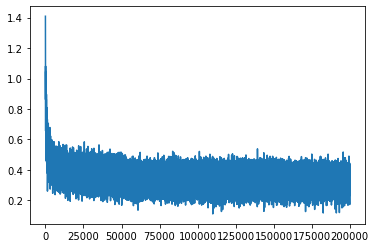

In [11]:
plt.plot(stepi, lossi)

In [12]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1,30) @ W1 + b1) # (32,100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1395, grad_fn=<NllLossBackward0>)

In [13]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1,30) @ W1 + b1) # (32,100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1698, grad_fn=<NllLossBackward0>)

In [14]:
emb = C[Xte]
h = torch.tanh(emb.view(-1,30) @ W1 + b1) # (32,100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.1717, grad_fn=<NllLossBackward0>)

In [15]:
# sample from the model
# g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

kaine.
ash.
capridteb.
maneah.
berty.
amariola.
atne.
ison.
teyiah.
yam.
dyn.
mourna.
kiya.
omany.
kugredheiron.
lay.
zora.
brumn.
mcantocier.
daldalei.


# Exercise 1.

Tune the hyperparameters of the training to beat my best validation loss of 2.2

In [16]:
# we should (without increasing number of steps):
# find optimal way to change lr
# find optimal batch size
# change hidden layer
# initizalise weights (next exercise)
# change activation function to LeakyReLU (optional)

In [17]:
#regularizations
regs = {}

regs['L1'] = lambda x, lamb: lamb*(x).mean()
regs['L2'] = lambda x, lamb: lamb*(x**2).mean()
regs['ElasticNet'] = lambda x, lamb: regs['L1'](x, lamb) + regs['L2'](x, lamb)
regs['None'] = lambda x, lamb: 0

In [18]:
# create class MLP to not repeat code or manualy change numbers every time we want to change hyperparams

class MLP():
    def __init__(self, embedding_size = 10, 
                 hidden_size = 200,
                 block_size = 3, 
                 vocab_size = 27,
                 batch_size = 32, 
                 lr = 0.1,
                 skip_connections = False):
        #sizes
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.block_size = block_size
        self.vocab_size = vocab_size
        self.batch_size = batch_size
        
        
        self.lr = lr
        
        #regularization and skip_connections
        self.skip_connections = skip_connections
        self.reg = regs['None']
        self.lamb = 0.01
        
        self.hyperparams = [self.embedding_size, self.hidden_size, self.block_size, self.vocab_size, self.batch_size]
    
    def init_weights(self):
        self.C = torch.randn((self.vocab_size,self.embedding_size))
        self.W1 = torch.randn((self.block_size*self.embedding_size,self.hidden_size))
        self.b1 = torch.randn(self.hidden_size)
        self.W2 = torch.randn((self.hidden_size,self.vocab_size))
        self.b2 = torch.randn(self.vocab_size)
        
#       perfect uniform for exercise 3
#         self.C = torch.empty((self.vocab_size,self.embedding_size)).uniform_(0,1)
#         self.W1 = torch.empty((self.block_size*self.embedding_size,self.hidden_size)).uniform_(0,1)
#         self.b1 = torch.empty(self.hidden_size).uniform_(0,1)
#         self.W2 = torch.empty((self.hidden_size,self.vocab_size)).uniform_(0,1)
#         self.b2 = torch.empty(self.vocab_size).uniform_(0,1)

        self.parameters = [self.C, self.W1, self.b1, self.W2, self.b2]
    
        if self.skip_connections:
            self.Ws = torch.randn(self.block_size*self.embedding_size,self.vocab_size)
            self.parameters.append(self.Ws)
        
        for p in self.parameters:
            p.requires_grad = True  
            
    def n_parameters(self):
        
        return sum(p.nelement() for p in self.parameters)
        
    def forward(self, X):
        emb = self.C[X] # (X.size,embedding_size,block_size) 
        
        h = torch.tanh(emb.view(-1,self.block_size*self.embedding_size) @ self.W1 + self.b1)
        #(X.size,block_size*embedding_size) @ (block_size*embedding_size,hidden_size) ------>  (X.size,hidden_size)
        logits = h @ self.W2 + self.b2 
        # (X.size,hidden_size) @ (hidden_size, vocab_size) -----> (X.size, vocab_size)
        if self.skip_connections:
                logits += emb.view(-1,self.block_size*self.embedding_size) @ self.Ws
                # (X.size, vocab_size) + (X.size,block_size*embedding_size) @ (block_size*embedding_size,vocab_size)
                #----> (X.size, vocab_size+bs*es)
        return logits
    
        
    def train(self, X, Y, steps = 10000):
        
        lossi = []
        
        for i in range(steps):
    
            #minibatch construct
            ix = torch.randint(0, X.shape[0], (self.batch_size,))

            #forward pass
            logits = self.forward(X[ix])
            loss = F.cross_entropy(logits, Y[ix]) + self.reg(self.W2,self.lamb)
            

            #backward pass
            for p in self.parameters:
                p.grad = None
            loss.backward()

            #update lr
            if i%(steps/4) == steps/4-1:
                self.lr /=4
                print(f'lr was changed to the value: {self.lr}')
                
                
            #update weights
            for p in self.parameters:
                p.data += -self.lr * p.grad

            # track stats
            lossi.append(loss.item()) 
            
        return lossi
    
    def evaluate(self, X, Y):
        logits = self.forward(X)
        
        loss = F.cross_entropy(logits, Y) + self.reg(self.W2,self.lamb)
        
        return loss.item()
    
    def generate(self, number = 10):
        
        names = []
        
        for _ in range(number):

            out = []
            context = [0] * self.block_size # initialize with all ...
            while True:
                logits = self.forward(torch.tensor([context]))
                probs = F.softmax(logits, dim=1)
                
                ix = torch.multinomial(probs, num_samples=1).item()
                context = context[1:] + [ix]
                out.append(ix)
                if ix == 0:
                    break
            names.append(''.join(itos[i] for i in out))
        
        return names

In [19]:
# init hyperparams
hyperparams = {
    'hidden_size': 200,
    'batch_size': 32,
}
steps = 200000

In [20]:
# init model
nn = MLP(
     **hyperparams
)
nn.init_weights()

nn.n_parameters()

11897

In [21]:
start_loss = nn.evaluate(Xtr, Ytr)
start_loss

26.445127487182617

In [22]:
loss = nn.train(Xtr,Ytr,steps)

lr was changed to the value: 0.025
lr was changed to the value: 0.00625
lr was changed to the value: 0.0015625
lr was changed to the value: 0.000390625


In [23]:
train_loss = nn.evaluate(Xtr, Ytr)
print(f'Train loss with default parameters: {train_loss:.4f}')
dev_loss = nn.evaluate(Xdev, Ydev)
print(f'Dev loss with default parameters: {dev_loss:.4f}')
test_loss = nn.evaluate(Xte, Yte)
print(f'Test loss with default parameters: {test_loss:.4f}')

Train loss with default parameters: 2.1412
Dev loss with default parameters: 2.1719
Test loss with default parameters: 2.1723


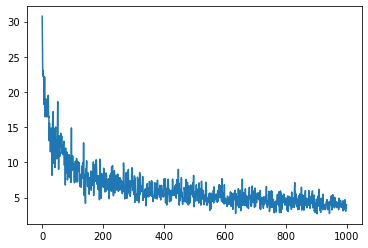

In [24]:
plt.plot(range(steps)[0:1000],loss[0:1000])

In [25]:
for name in nn.generate():
    print(name)

naruchliy.
glery.
keso.
skcis.
paliah.
anah.
krom.
rah.
perraid.
azala.


In [26]:
# let's check the loss if we increase embedding size to 20

In [27]:
steps = 200000

nn = nn = MLP(
     **hyperparams,
    embedding_size= 20
)
nn.init_weights()

nn.n_parameters()

18167

In [28]:
loss = nn.train(Xtr,Ytr,steps)

lr was changed to the value: 0.025
lr was changed to the value: 0.00625
lr was changed to the value: 0.0015625
lr was changed to the value: 0.000390625


In [29]:
train_loss = nn.evaluate(Xtr, Ytr)
print(f'Train loss with default parameters: {train_loss:.4f}')
dev_loss = nn.evaluate(Xdev, Ydev)
print(f'Dev loss with default parameters: {dev_loss:.4f}')
test_loss = nn.evaluate(Xte, Yte)
print(f'Test loss with default parameters: {test_loss:.4f}')

Train loss with default parameters: 2.0753
Dev loss with default parameters: 2.1497
Test loss with default parameters: 2.1524


In [30]:
#We  get improvement in our model, so 10 emb_size is not fully representing words in 10-dim space
#With future train we can achive better result, we will see this at the end.

In [31]:
for name in nn.generate():
    print(name)

markinan.
zhan.
kaily.
aliz.
jaylen.
zari.
blushiklennika.
jamirashailoh.
kenianna.
kamsai.


# Exercise 2.

I was not careful with the intialization of the network in this video. (1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve? (2) Can you tune the initialization to get a starting loss that is much more similar to (1)?

## Visualizing  goal and current state

In [32]:
# create functions to get statistic
def mean(distr):
    return sum(distr)/len(distr)
               
def variance(distr):
    mean_ = mean(distr)
    return sum((i - mean_) ** 2 for i in distr) / len(distr)

In [33]:
# let's get distib from last layer as list
distrib_W2 = nn.W2.view(-1).tolist()

distrib_mean = sum(distrib_W2)/len(distrib_W2)
print(f'Mean of the output layer is {distrib_mean}')

distrib_variance = sum((i - distrib_mean) ** 2 for i in distrib_W2) / len(distrib_W2)
print(f'Varience of the output layer is {distrib_variance}')

Mean of the hidden layer is 0.00845228200840615
Varience of the hidden layer is 0.1903990185046878


In [34]:
init_distr = torch.randn((30,200)).view(-1).tolist()


init_mean = sum(init_distr)/len(init_distr)
print(init_mean)

init_variance = sum((i - init_mean) ** 2 for i in init_distr) / len(init_distr)
print(init_variance)

-0.004302807953216567
1.0202582633770982


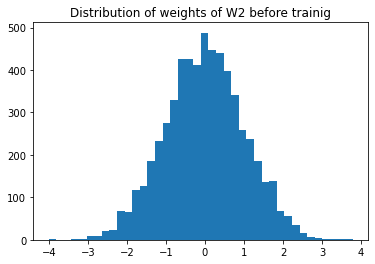

In [35]:
plt.hist(init_distr,40)

plt.title('Distribution of weights of W2 before trainig')

plt.show()

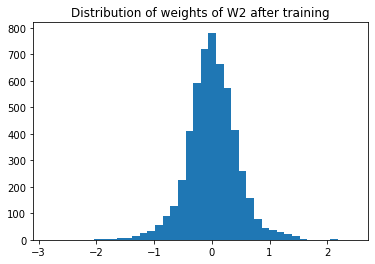

In [36]:
plt.hist(distrib_W1,40)

plt.title('Distribution of weights of W2 after training')

plt.show()

In [37]:
uniform = torch.zeros(10000).uniform_(-1,1).tolist()

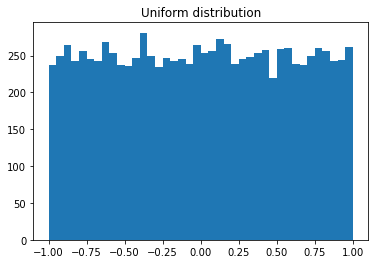

In [38]:
plt.hist(uniform,40)

plt.title('Uniform distribution')

plt.show()

In [39]:
#To make uniform distrib more uniform-like:
#add or deduct values according to their deviation from variance

In [40]:
#realization
trunc = lambda x: x+2*init_variance if (x<=-2*init_variance) else x+init_variance if (x<=-init_variance) else x if (x<=init_variance) else  x-init_variance if (x<=2*init_variance) else  x-2*init_variance
uniform_like = [trunc(i) for i in init_distr]

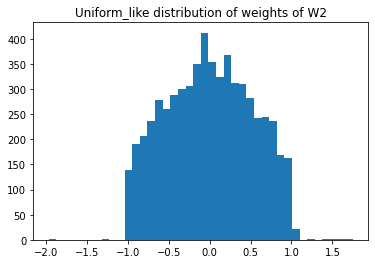

In [41]:
plt.hist(uniform_like,40)

plt.title('Uniform_like distribution of weights of W2')

plt.show()

## Check initial loss

In [42]:
# check loss for current init

In [43]:
loss_default = []
steps = 100

for _ in range(steps):
    nn = MLP()
    nn.init_weights()
    
    loss = nn.evaluate(Xtr, Ytr)
    
    loss_default.append(loss)

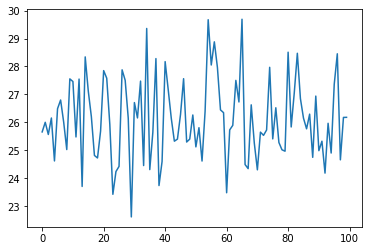

In [44]:
plt.plot(range(100), loss_default)

In [45]:
#----hyperparams----
vocab_size = 27
embedding_size = 10
block_size = 3
hidden_size = 200

In [46]:
# create loop for checking loss with uniform init

In [47]:
loss_uniform = []
steps = 100

for _ in range(steps):
    # init weights
    C = torch.empty((vocab_size,embedding_size)).uniform_(0,1)
    W1 = torch.empty((block_size*embedding_size,hidden_size)).uniform_(0,1)
    b1 = torch.empty(hidden_size).uniform_(0,1)
    W2 = torch.empty((hidden_size,vocab_size)).uniform_(0,1)
    b2 = torch.empty(vocab_size).uniform_(0,1)
    
    emb = C[Xtr] # (32,10,3) 
    h = torch.tanh(emb.view(-1,30) @ W1 + b1) # (32,100)
    logits = h @ W2 + b2 # (32, 27)
    
    loss = F.cross_entropy(logits, Ytr)
    loss_uniform.append(loss.item())

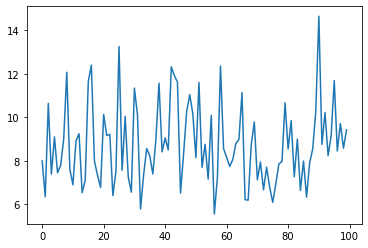

In [48]:
plt.plot(range(100),loss_uniform)

In [49]:
#start loss goes from 23-30 to 5-14, so we need little steps to reach plato

#let's check mean and variance of our losses

In [50]:
d_mean = mean(loss_default)
d_var = variance(loss_default)
print(f'For default initialization mean  is {d_mean}, variance is {d_var}')

For default initialization mean  is 26.12179811477661, variance is 2.077187946103098


In [51]:
u_mean = mean(loss_uniform)
u_var = variance(loss_uniform)
print(f'For uniform initialization mean  is {u_mean}, variance is {u_var}')

For uniform initialization mean  is 8.727249026298523, variance is 3.359528293635938


In [52]:
# now let's tune init distribution with our function

## Tunning

In [53]:
loss_tuned = []
steps = 100

for _ in range(steps):
    nn = MLP()
    nn.init_weights()
    for p in nn.parameters:
        p.requires_grad = False
        p.apply_(trunc)
        p.requires_grad = True
        
    loss = nn.evaluate(Xtr, Ytr)
    loss_tuned.append(loss)

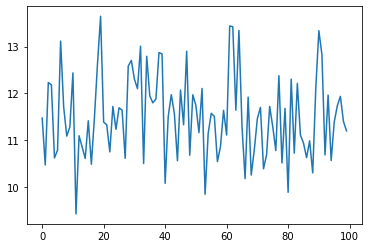

In [54]:
plt.plot(range(steps),loss_tuned)

In [55]:
t_mean = mean(loss_tuned)
t_var = variance(loss_tuned)
print(f'For tuned initialization mean  is {t_mean}, variance is {t_var}')

For tuned initialization mean  is 11.520183057785035, variance is 0.7908717603406598


## Train model with tuned initalization

In [56]:
def tune_init(model):
    for p in model.parameters:
        p.requires_grad = False
        p.apply_(trunc)
        p.requires_grad = True  

In [57]:
nn = MLP()
nn.init_weights()
tune_init(nn)

steps = 200000

In [58]:
loss = nn.train(Xtr, Ytr, steps)

lr was changed to the value: 0.025
lr was changed to the value: 0.00625
lr was changed to the value: 0.0015625
lr was changed to the value: 0.000390625


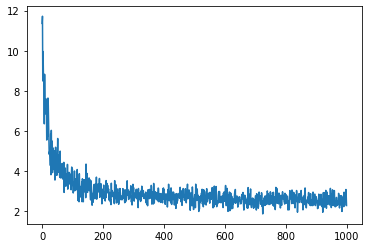

In [59]:
plt.plot(range(steps)[0:1000],loss[0:1000])

In [60]:
train_loss = nn.evaluate(Xtr, Ytr)
print(f'Train loss with tuned init: {train_loss:.4f}')
dev_loss = nn.evaluate(Xdev, Ydev)
print(f'Dev loss with tuned init: {dev_loss:.4f}')
test_loss = nn.evaluate(Xte, Yte)
print(f'Test loss with tuned init: {test_loss:.4f}')

Train loss with tuned init: 2.0956
Dev loss with tuned init: 2.1312
Test loss with tuned init: 2.1315


In [61]:
for name in nn.generate():
    print(name)

brynie.
rola.
iyana.
sarbin.
najahmadelisabyya.
deonton.
fir.
maira.
maleigh.
key.


As the result, proper init distribution can reduce loss and make our model much better

# Exercise 3.

Read the Bengio et al 2003 paper (link above), implement and try any idea from the paper. Did it work?

In [62]:
# let's add skip connections and regularization: 
# skip connections - concat end logits with embedding vectors 
# regularization - add L2 to the loss function

In [63]:
# add additional W-matrix (block_size*embedding_size,vocab_size) to convert embedding to outputs
# in forward pass we add:
##if self.skip_connections:
##    logits += emb.view(-1,self.block_size*self.embedding_size) @ self.Ws
# we add reg to loss function

In [64]:
nn = MLP(skip_connections=True)

steps = 200000

nn.init_weights()
tune_init(nn)
nn.reg = regs['L2']



nn.n_parameters()

12707

In [65]:
loss = nn.train(Xtr, Ytr, steps)

lr was changed to the value: 0.025
lr was changed to the value: 0.00625
lr was changed to the value: 0.0015625
lr was changed to the value: 0.000390625


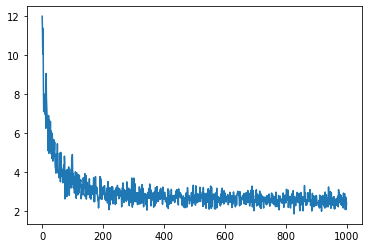

In [66]:
plt.plot(range(steps)[0:1000],loss[0:1000])

In [67]:
train_loss = nn.evaluate(Xtr, Ytr)
print(f'Train loss with tuned parameters and skip_connections: {train_loss:.4f}')
dev_loss = nn.evaluate(Xdev, Ydev)
print(f'Dev loss with tuned parameters and skip_connections: {dev_loss:.4f}')
test_loss = nn.evaluate(Xte, Yte)
print(f'Test loss with tuned parameters and skip_connections: {test_loss:.4f}')

Train loss with tuned parameters and skip_connections: 2.0970
Dev loss with tuned parameters and skip_connections: 2.1331
Test loss with tuned parameters and skip_connections: 2.1297


In [68]:
for name in nn.generate():
    print(name)

kolvin.
omni.
faue.
lybe.
cen.
garcinley.
aleeno.
jayza.
kenzidra.
jere.


Now we have more information to predict (logits+embeddings instead of only logits) and have fewer chances to overfitting due to regularization, so we can take more steps

# Best model with highest score

In [69]:
# Here let's try to achieve the lowest lost we can get

In [70]:
# init hyperparams
hyperparams = {
    'block_size': 4,
    'embedding_size':15,
    'hidden_size': 250,
    'batch_size': 64,
}
steps = 400000

In [71]:
# build the dataset with splits
block_size = hyperparams['block_size'] 

random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182473, 4]) torch.Size([182473])
torch.Size([22827, 4]) torch.Size([22827])
torch.Size([22846, 4]) torch.Size([22846])


In [72]:
nn_best = MLP(
    **hyperparams,
skip_connections=True
)

nn_best.init_weights()
tune_init(nn_best)
nn_best.reg = regs['L2']

nn_best.n_parameters()

24052

In [73]:
loss =  nn_best.train(Xtr,Ytr, steps)

lr was changed to the value: 0.025
lr was changed to the value: 0.00625
lr was changed to the value: 0.0015625
lr was changed to the value: 0.000390625


In [74]:
train_loss = nn_best.evaluate(Xtr, Ytr)
print(f'Train loss with best hyperparams: {train_loss:.4f}')
dev_loss = nn_best.evaluate(Xdev, Ydev)
print(f'Dev loss with best hyperparams: {dev_loss:.4f}')
test_loss = nn_best.evaluate(Xte, Yte)
print(f'Test loss with best hyperparams: {test_loss:.4f}')

Train loss with best hyperparams: 1.9460
Dev loss with best hyperparams: 2.0563
Test loss with best hyperparams: 2.0570


In [75]:
for name in nn_best.generate():
    print(name)

tim.
emarriah.
maho.
atha.
hollistes.
kylia.
franke.
laiel.
othan.
pinchelomena.


Best test loss we achieved is 2.0570